In [1]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from utils import load_dataset_df, smile_to_fp,smiles_to_descriptor,smiles_to_onehot, smiles_to_onehot_selfies, data_splitter, get_spiking_net, make_filename
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score
from csnn_model import get_prediction_fn

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometri

In [2]:
import sys
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_path = f"./results/logs/output_{timestamp}.txt"
log_file = open(log_path, "w")
sys.stdout = log_file


#### Load DataFrame

In [3]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[1]
dirname = dt_file.removesuffix('.csv')

df, targets = load_dataset_df(filename=dt_file)

for t in targets:
    df_temp = df[[t, 'smiles']].dropna()
    class_counts = df[t].count()
    class_sum = df[t].sum()
    print(t, class_counts, round(class_sum/class_counts, 2)) 


In [4]:
if dirname == 'tox21':
    # SR-ARE
    target_name = targets[7]
    # SR-MMP
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()

#### Molecular Representation

In [5]:
representations = ["fp", "descriptor", "SELFIES-1hot", "SMILES-1hot"]#, "graph-list"]

repr_type = representations[0]

In [6]:
if repr_type == "fp":
    fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['count_morgan', 1024], ['pubchem', 881]]
    mix = False
    fp_type, num_bits = fp_types[1]
    if mix and fp_type == 'RDKit':
        num_bits = 512
    data_config = {"fp_type": fp_type,
                "num_bits": num_bits,
                "radius": 2,
                "fp_type_2": fp_types[0][0],
                "num_bits_2": 1024 - num_bits,
                "mix": mix,}
    dim_2 = False
    print(fp_type, '-', num_bits)
    if mix: print(data_config['fp_type_2'], '-', data_config['num_bits_2'])
    if dim_2: print("2D FP")

elif repr_type == "descriptor":
    desc_type = ["RDKit", "TODO"]
    data_config = {"desc": desc_type[0],
                   "size": 0,
                }
elif repr_type == "SELFIES-1hot":
    dim_2 = True
    data_config = {}

elif repr_type == "SMILES-1hot":
    dim_2 = True
    data_config = {}

data_config["repr_type"] = repr_type
print(repr_type)

In [7]:
dtype = torch.float
split = "scaffold"
dataset = None

if dirname != 'BBBP':
    split = "random"
    if repr_type == "fp":
        fp_array, target_array = smile_to_fp(df, data_config=data_config, target_name=target_name)
        # Create Torch Dataset
        fp_tensor = torch.tensor(fp_array, dtype=dtype)
        print(fp_tensor.size())
        target_tensor = torch.tensor(target_array, dtype=dtype).long()
        if dim_2:
            fp_tensor = fp_tensor.view(-1, 32, 32)
            print(fp_tensor.size())
        dataset = TensorDataset(fp_tensor, target_tensor)
    elif repr_type == "descriptor":
        desc_array, target_array = smiles_to_descriptor(df, data_config=data_config, target_name=target_name, missing_val=0)
        # Create Torch Dataset
        desc_tensor = torch.tensor(desc_array, dtype=dtype)
        target_tensor = torch.tensor(target_array, dtype=dtype).long()

        dataset = TensorDataset(desc_tensor, target_tensor)
        print(desc_tensor.size())
    elif repr_type == "SELFIES-1hot":
        selfies_array, target_array = smiles_to_onehot_selfies(df, data_config=data_config, target_name=target_name, missing_val=0)
        # Create Torch Dataset
        selfies_tensor = torch.tensor(selfies_array, dtype=dtype)
        target_tensor = torch.tensor(target_array, dtype=dtype).long()

        dataset = TensorDataset(selfies_tensor, target_tensor)
        print(selfies_tensor.size())
    elif repr_type == "SMILES-1hot":
        smiles_array, target_array = smiles_to_onehot(df, data_config=data_config, target_name=target_name, missing_val=0)
        # Create Torch Dataset
        smiles_tensor = torch.tensor(smiles_array, dtype=dtype)
        target_tensor = torch.tensor(target_array, dtype=dtype).long()

        dataset = TensorDataset(smiles_tensor, target_tensor)
        print(smiles_tensor.size())

[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:28] WARNING: not removing hydrogen atom without neighbors
[16:32:30] WARNING: not removing hydrogen atom without neighbors
[16:32:30] WARNING: not removing hydrogen atom without neighbors
[16:32:30] WARNING: not removing hydrogen atom without neighbors
[16:32:31] WARNING: not removing hydrogen atom without neighbors
[16:32:31] WARNING: not removing hydrogen atom without neighbors


In [8]:
if repr_type == "SMILES_1hot":
    longest_smiles = df.loc[df['smiles'].str.len().idxmax(), 'smiles']
    print(longest_smiles)

    from rdkit import Chem

    mol = Chem.MolFromSmiles(longest_smiles)
    print("Valid" if mol else "Invalid")
    cc = df[df['smiles'].str.len() > 256]

    print(len(cc))
    sample1 = smiles_array[0]
    print(sample1)
    print(selfies_tensor.size())

In [9]:
if repr_type == "descriptor":
    from rdkit.Chem import  Descriptors
    print("desc_array Has NaNs:", np.isnan(desc_array).any())
    print("desc_array Has Infs:", np.isinf(desc_array).any())
    print("desc_tensor has nans:", torch.isnan(desc_tensor).any().item())
    print("desc_tensor has infs:", torch.isinf(desc_tensor).any().item())

    print("Max value in desc_array:", np.max(desc_array))

    # Find the index of the max value in the array
    max_idx = np.argmax(desc_array)  # Returns the index of the max value in flattened array

    # Find the corresponding row and descriptor index
    row_idx = max_idx // desc_array.shape[1]  # Row index (which molecule)
    desc_idx = max_idx % desc_array.shape[1]  # Descriptor index (which descriptor)
    print(f"Max value at row {row_idx}, descriptor {desc_idx} with value: {desc_array[row_idx, desc_idx]}")

    for k, (nm, fn) in enumerate(Descriptors._descList):
        print(k, nm)


#### Loss Function

In [10]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['ce_mem', 'rate_loss', 'count_loss', 'temporal_loss', 'bce_loss']
loss_type = loss_types[0]
print(loss_type)


#### Train Loop

In [11]:
net_types = ["SNN", "DSNN", "CSNN", "RSNN"]
net_type = net_types[0]
slope = 10
#spike_grad = surrogate.fast_sigmoid(slope=slope)
spike_grad = None
beta = 0.95 
bias = True
net_config = {
            "num_hidden": 1024,
            "num_hidden_l2": 256,
            "num_steps": 10,
            "spike_grad": spike_grad,
            "slope": None if not spike_grad else slope, #spike_grad.__closure__[0].cell_contents,
            "beta": beta,
            "encoding": 'rate' if loss_type != 'temporal_loss' else 'ttfs',
            "bias": bias,
            "out_num": 2
            }
if net_type == "CSNN":
    net_config['num_conv'] = 1
    net_config['stride'] = [1 for _ in range(net_config['num_conv'])]
    net_config["pool_size"] = 2
    net_config["conv_kernel"] = 3
    net_config["conv_stride"] = 1
    net_config["conv_groups"] = 1

if repr_type == "fp":
    net_config["input_size"] = 1024 if data_config['mix'] else num_bits
    net_config["2d"] = dim_2

elif repr_type == "descriptor":
    net_config["input_size"] = desc_tensor.shape[1]
    net_config["2d"] = False
    net_config["time_steps"] = 10

if repr_type == "SELFIES-1hot":
    net_config["input_size"] = [desc_tensor.shape[1],desc_tensor.shape[2]] 
    net_config["2d"] = True
if repr_type == "SMILES-1hot":
    net_config["2d"] = True
    net_config["input_size"] = [desc_tensor.shape[1],desc_tensor.shape[2]] 
print(net_type)

In [12]:
   
pop_coding = net_config['out_num'] > 2
lr=1e-4 #1e-6 default for 1000 epochs. csnn requires higher
iterations = 30
weight_decay = 0 # 1e-5
optim_type = 'Adam'
#optim_type = 'SGD'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16 #16, 8
train_config = {"num_epochs": 1000,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['num_steps'],
                'val_net': None,
                'prediction_fn': get_prediction_fn(encoding=net_config['encoding'], pop_coding=pop_coding),
                }
drop_last = net_type == "CSNN"
pin_memory = device == "cuda"
save_csv = True
save_models = True
results = [[], [], [], [], [], []]

In [13]:
print("-----Configuration-----")
print(data_config)
print(net_config)
print(train_config)

In [14]:
from rdkit import RDLogger

# Disable RDKit logging for the scaffold meeting
RDLogger.DisableLog('rdApp.*')


In [15]:
def calc_metrics(metrics_list, all_targets, all_preds):
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    
    metrics_list[0].append(accuracy)
    metrics_list[1].append(auc_roc)
    metrics_list[2].append(sensitivity)
    metrics_list[3].append(specificity)
    metrics_list[4].append(f1)
    metrics_list[5].append(precision)
    

In [16]:
def zscore_norm(train_subset, val_subset, test_subset):
    train_tensor, _ = train_subset[:]
    val_tensor, _ = val_subset[:]
    test_tensor, _ = test_subset[:]

    mean = train_tensor.mean(dim=0)
    std = train_tensor.std(dim=0)
    std = std.clamp(min=1e-6)
    #print(mean.size())
    train_norm = (train_tensor - mean)
    #print(torch.isnan(train_tensor).any())
    #print(torch.isnan(train_norm).any())
    train_norm = train_norm / std
    #print(torch.isnan(train_norm).any())
    val_norm = (val_tensor - mean) / std
    test_norm = (test_tensor - mean) / std

    return train_norm, val_norm, test_norm

def minmax_norm(train_subset, val_subset, test_subset):
    train_tensor, _ = train_subset[:]
    val_tensor, _ = val_subset[:]
    test_tensor, _ = test_subset[:]

    min_val = train_tensor.min(dim=0).values
    max_val = train_tensor.max(dim=0).values
    range_val = (max_val - min_val).clamp(min=1e-6)

    train_norm = ((train_tensor - min_val) / range_val).clamp(0.0, 1.0)
    val_norm   = ((val_tensor   - min_val) / range_val).clamp(0.0, 1.0)
    test_norm  = ((test_tensor  - min_val) / range_val).clamp(0.0, 1.0)

    return train_norm, val_norm, test_norm


In [17]:
import time
times = []

In [ ]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    seed = iter + 1
    print(f"Seed:{seed}")
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    net, train_net, val_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    train_config['val_net'] = val_net
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #optimizer = torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    train_config["scheduler"] = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_config['num_epochs'])
    
    # DATA SPLIT
    train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, data_config=data_config, seed=seed, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
        
    if repr_type == "descriptor":
        train_data, val_data, test_data = minmax_norm(train, val, test)
        train = TensorDataset(train_data, train_label)
        val = TensorDataset(val_data,val_label)
        test = TensorDataset(test_data, test_label)


    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

    # LOSS FN
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1], dtype=np.int8), y=np.array(train_label, dtype=np.int8))
    #class_weights[0] = class_weights[0]/2 
    #class_weights[0] = class_weights[0]*2
    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights, pop_coding=pop_coding)


    # TRAINING
    start_time = time.time()
    net, loss_hist, val_acc_hist, val_auc_hist, net_list = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config, net_config=net_config)
    end_time = time.time()
    train_time = end_time - start_time
    times.append(train_time)
    print()
    print(f"Time: {train_time:.4f} seconds")
    # TESTING
    model = net
    """
    best_test_auc = 0
    best_epoch = 0
    for index, model_dict in enumerate(net_list):
        model.load_state_dict(model_dict)
        model.to(device)
        all_preds2, all_targets2 = test_net(model, device, test_loader, train_config)
        auc_roc_test = roc_auc_score(all_targets2, all_preds2)
        if auc_roc_test > best_test_auc:
            best_test_auc, best_epoch = (auc_roc_test, index)

    print('-- best epoch:', best_epoch,'--best auc:', best_test_auc)
    model.load_state_dict(net_list[best_epoch]) """
    if save_models:
        filename = make_filename(dirname, target_name, net_type, data_config, lr, weight_decay, optim_type, net_config, train_config, model, model = True)
        model_name = filename.removesuffix('.csv') + f"seed-{seed}" +'.pth'
        torch.save(model.state_dict(), model_name)

    all_preds, all_targets = test_net(model, device, test_loader, train_config)
    auc_roc_test = roc_auc_score(all_targets, all_preds)
    print('AUC on test set:', auc_roc_test)
    calc_metrics(results, all_preds=all_preds, all_targets=all_targets)

In [ ]:
print(sum(times)/len(times))

In [ ]:
print(net)

#### Smoothed Loss

C:\Users\knsve\AppData\Local\Temp\ipykernel_20372\4265383385.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


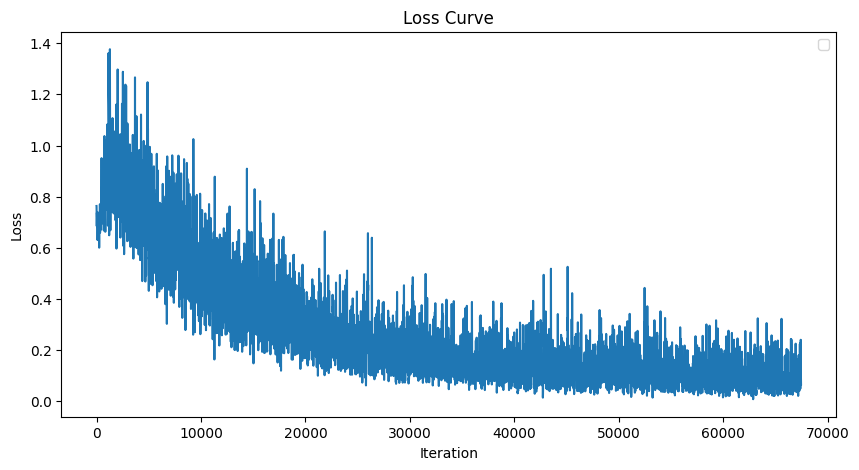

In [ ]:
#from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
#from statsmodels.nonparametric.smoothers_lowess import lowess

#print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
#plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
num_epochs = train_config['num_epochs']
num_minibatches_per_epoch = len(loss_hist) // num_epochs

# Create x-axis values in terms of epochs
epochs = np.linspace(1, num_epochs, len(loss_hist))
epoch_losses = np.array(loss_hist).reshape(num_epochs, num_minibatches_per_epoch).mean(axis=1)

plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

ValueError: cannot reshape array of size 67452 into shape (1000,67)

C:\Users\knsve\AppData\Local\Temp\ipykernel_20372\1552820167.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


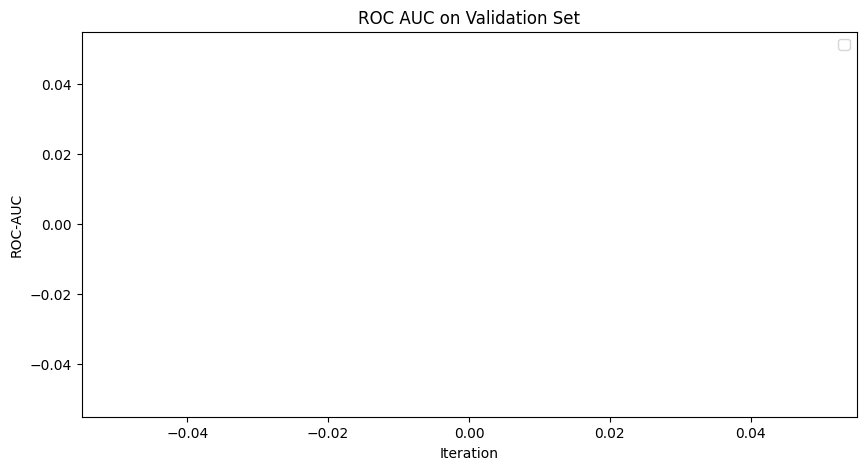

In [ ]:
# Validation Set
fig = plt.figure(facecolor="w", figsize=(10, 5))

#plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
plt.plot(val_auc_hist)
plt.title("ROC AUC on Validation Set")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()

#### Save Metrics

In [ ]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']

# TODO: Add neuron thresholds to name
filename = make_filename(dirname, target_name, net_type, data_config, lr, weight_decay, optim_type, net_config, train_config, model)
if save_csv: df_metrics.to_csv(filename, index=False)

print(filename)

In [ ]:
results[1]

In [ ]:
min_auc = np.argmin(results[1])
print("min auc:", results[1][min_auc], "at", min_auc)

max_auc = np.argmax(results[1])
print("max auc:", results[1][max_auc], "at", max_auc)